In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipyparallel as ipp
import matplotlib.pyplot as plt
import msprime
import numpy as np
import pandas as pd
from itertools import combinations
from IPython.display import display

In [10]:
# Connect to the ipyclient if you want to parallelize replicates
ipyclient = ipp.Client(cluster_id="pistar")
print(len(ipyclient))

40


In [11]:
def get_pi(haplotypes):
    ## If no seg sites in a pop then haplotypes will be 0 length
    if haplotypes.size == 0:
        return 0
    n = len(haplotypes[0])
    n_comparisons = float(n) * (n - 1) / 2

    pi = 0
    for hap in haplotypes:
        k = np.count_nonzero(hap)
        pi += float(k) * (n - k) / n_comparisons
    return(pi)

In [12]:
# Run `reps` number of simulations accumulating pi and pi* values
# returns a tuple of pi*/pi vectors
def simulate(ss=10, Ne=1e4, length=5e2, reps=100, verbose=False):
    if verbose: print("s:{} Ne:{} len:{}".format(ss, int(Ne), int(length)))
    ts_pis = []
    my_pis = []
    uniq_pis = []
    nuniq = 0
    for i in range(reps):
        tree_sequence = msprime.simulate(sample_size=ss, Ne=Ne, length=length, mutation_rate=1e-8)
        ts_pis.append(tree_sequence.get_pairwise_diversity()/length)

        haps = list(tree_sequence.haplotypes())
        # Comment out _my_ pi implentation since I've demonstrated that it is exact
        # wrt msprime get_pairwise_diversity(), but msprime is faster. Saves time.
        #haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        #my_pis.append(get_pi(haps_t)/length)

        haps = set(haps)
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        uniq_pis.append(get_pi(haps_t)/length)
        nuniq += len(haps)

    if verbose:
        print("  TS:\t\t\t{:.5f}/{:.5f}".format(np.mean(ts_pis), np.std(ts_pis)))
        #print("  My: {:.5f}/{:.5f}".format(np.mean(my_pis), np.std(my_pis)))
        print("  Uniq (avg# {}):\t{:.5f}/{:.5f}".format(nuniq/float(reps),
                                            np.mean(uniq_pis),
                                            np.std(uniq_pis)))

    return ts_pis, uniq_pis

# Ne 10000, 500bp loci
for ss in [5, 10, 25, 50]:
    _, _ = simulate(ss=ss, reps=100, verbose=True)

s:5 Ne:10000 len:500
  TS:			0.00048/0.00070
  Uniq (avg# 1.45):	0.00097/0.00128
s:10 Ne:10000 len:500
  TS:			0.00050/0.00068
  Uniq (avg# 1.62):	0.00119/0.00132
s:25 Ne:10000 len:500
  TS:			0.00042/0.00060
  Uniq (avg# 1.68):	0.00120/0.00128
s:50 Ne:10000 len:500
  TS:			0.00046/0.00061
  Uniq (avg# 1.88):	0.00151/0.00135


In [13]:
# Manage running simulate() function over a range of Ne values.
# Returns a dataframe with columns of pi/pi* and indices of Ne values per simulation
# Default to using logspace for generating Ne steps, as action quickly converges for
# large values of Ne
def Ne_replicates(min_ne=1000, max_ne=1000000, step=30, ss=5, length=500, log=True, reps=100):
    df = pd.DataFrame(columns=["pi", "pi*"])
    if log:
        fun=np.logspace
        min_ne = np.log10(min_ne)
        max_ne = np.log10(max_ne)
    else:
        fun=np.linspace
    for Ne in fun(min_ne, max_ne, step):
        #print("{} ".format(Ne), end="")
        if log: np.power(Ne, 10)
        ts_pis, uniq_pis = simulate(Ne=Ne, reps=reps, ss=ss, length=length)
        df.loc[Ne] = [ts_pis, uniq_pis]
    return df
df5_5e2 = Ne_replicates(ss=5, length=5e2)
df50_5e2 = Ne_replicates(ss=50, length=5e2)

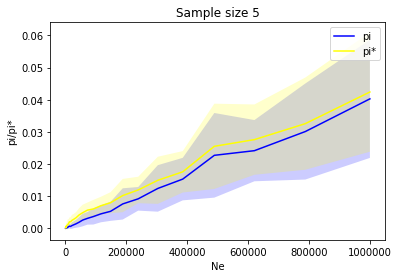

In [14]:
# Plot one replicate run of Ne values
# This plot contains the mean pi*/pi and +/- 1 sd (shaded)
def plot_Ne_replicates(df, title="", log=False):
    fig, ax = plt.subplots(1)
    if log:
        Nes = np.log10(df.index.values)
    else:
        Nes = df.index.values
    for p, c in zip(["pi", "pi*"], ['blue', 'yellow']):
        pi_means = df[p].apply(np.mean)
        pi_std = df[p].apply(np.std)
        ax.plot(Nes, pi_means, label=p, c=c)
        ax.fill_between(Nes, pi_means+pi_std, pi_means-pi_std, facecolor=c, alpha=0.2)
        ax.set_xlabel("Ne")
        ax.set_ylabel("pi/pi*")
        ax.set_title(title)
        ax.legend()
# length 500
plot_Ne_replicates(df50_5e2, title="Sample size 5")

In [10]:
## get more sims for the next figure
df5_5e2 = Ne_replicates(ss=5, length=5e2)
df50_5e2 = Ne_replicates(ss=50, length=5e2)
df5_5e3 = Ne_replicates(ss=5, length=5e3)
df50_5e3 = Ne_replicates(ss=50, length=5e3)
df5_650 = Ne_replicates(ss=5, length=650)
df50_650 = Ne_replicates(ss=50, length=650)

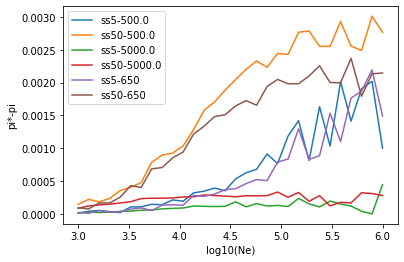

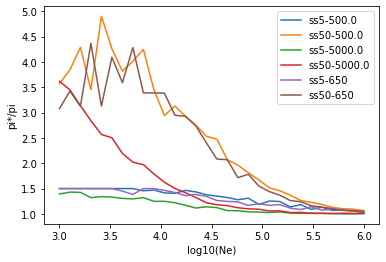

In [11]:
# Plotting one dataframe of pi*/pi values at a time
# You can get two different views here:
#  sub: pi* - pi - absolute difference
#  div: pi*/pi - ratio
# The different views give slightly different lens on the results
def plot_diffs(df1, df2, ax=None, diff="sub", length=500):
    if not ax:
        fig, ax = plt.subplots(1)
    Nes = np.log10(df1.index.values)
    if diff == "sub":
        small = df1["pi*"].apply(np.mean) - df1["pi"].apply(np.mean)
        large = df2["pi*"].apply(np.mean) - df2["pi"].apply(np.mean)
        ax.set_ylabel("pi*-pi")
    else:
        small = df1["pi*"].apply(np.mean)/df1["pi"].apply(np.mean)
        large = df2["pi*"].apply(np.mean)/df2["pi"].apply(np.mean)
        ax.set_ylabel("pi*/pi")
    ax.plot(Nes, small, label="ss5-{}".format(length))
    ax.plot(Nes, large, label="ss50-{}".format(length))
    ax.set_xlabel("log10(Ne)")
    ax.legend()
    return ax
ax5e2 = plot_diffs(df5_5e2, df50_5e2, length=5e2)
ax5e3 = plot_diffs(df5_5e2, df50_5e2, length=5e2, diff='div')
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e2, length=5e3)
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e3, length=5e3, diff='div')
_ = plot_diffs(df5_650, df50_650, ax=ax5e2, length=650)
_ = plot_diffs(df5_650, df50_650, ax=ax5e3, length=650, diff='div')

## Automate the process
Generating and plotting replicates and plotting the simulations one treatment
at a time is annoying, so bundle it all up into a function.

In [15]:
# Generate a dictionary with results enumerating combinations
# of sample size and sequence length.
def replicate(sss=[5, 10, 50],
             lengths=[500, 650, 1000, 5000],
             reps=100):
    res_dict = {}
    for ss in sss:
        for length in lengths:
            rep = "ss{}-len{}".format(ss, length)
            print(rep)
            res_dict[rep] = Ne_replicates(ss=ss, length=length, reps=reps)
    return res_dict
res_dict = replicate(reps=1000)

ss5-len500
ss5-len650
ss5-len1000
ss5-len5000
ss10-len500
ss10-len650
ss10-len1000
ss10-len5000
ss50-len500
ss50-len650
ss50-len1000
ss50-len5000


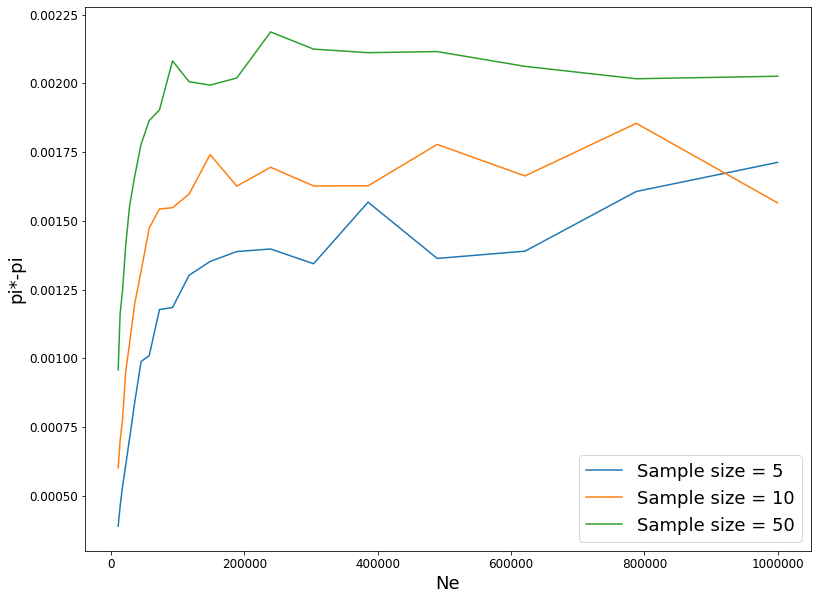

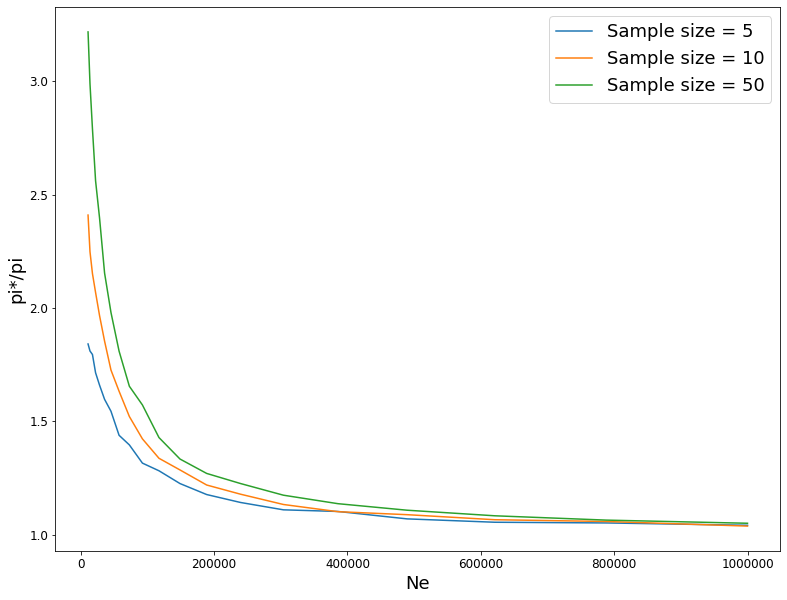

In [67]:
# Plot the dictionary of dataframes
plt.rcParams.update({'font.size': 12})

def plot_dict(dicts, ax=None, diff="sub", log=True, subset="", min_Ne_idx=0, fontsize=18):
    if subset:
        dicts = {k:v for k, v in dicts.items() if subset in k}
    if not ax:
        fig, ax = plt.subplots(1, figsize=(13, 10))
    Nes = np.log10(list(dicts.values())[0].index.values)
    for k, df in dicts.items():

        if diff == "sub":        
            dat = df["pi*"].apply(np.mean) - df["pi"].apply(np.mean)
        else:
            dat = df["pi*"].apply(np.mean)/df["pi"].apply(np.mean)
        k = f"Sample size = {k.split('-')[0].split('ss')[1]}"
        ax.plot(10**Nes[min_Ne_idx:], dat.values[min_Ne_idx:], label=k)

    ax.set_ylabel("pi*/pi", fontsize=fontsize)
    if diff == "sub": ax.set_ylabel("pi*-pi")
    #ax.set_xlabel("log10(Ne)", fontsize=fontsize)
    ax.set_xlabel("Ne", fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    return ax
subset = "-len650"
_ = plot_dict(res_dict, subset=subset, min_Ne_idx=10)
_ = plot_dict(res_dict, subset=subset, diff='div', min_Ne_idx=10)

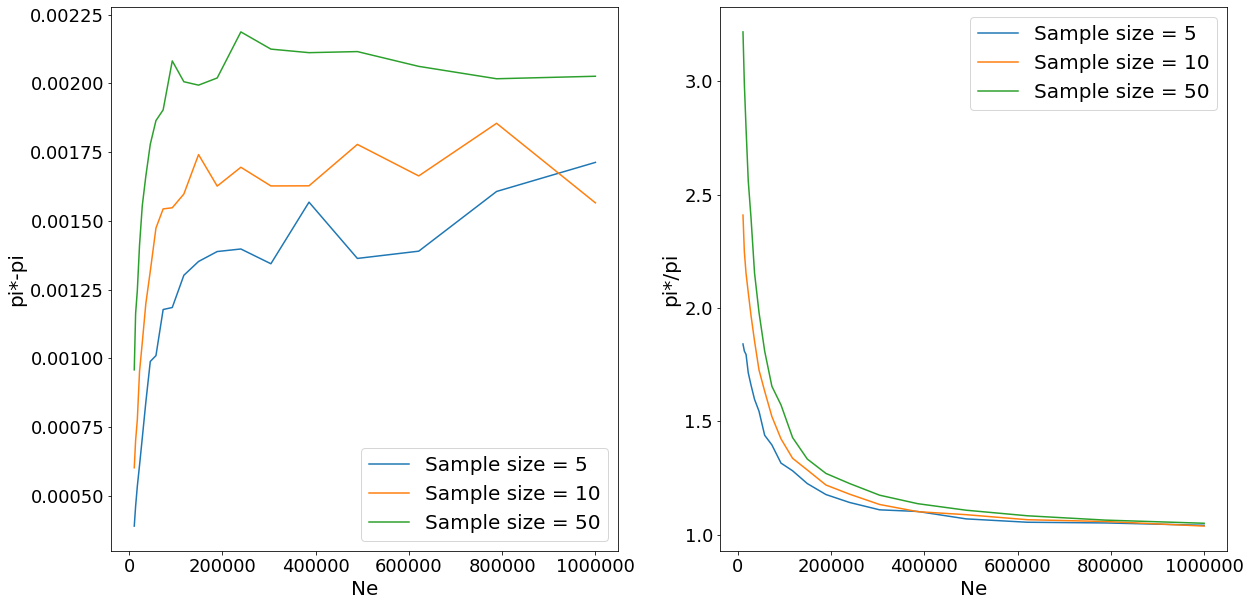

In [68]:
plt.rcParams.update({'font.size': 18})

fix, axs = plt.subplots(1, 2, figsize=(20, 10))
subset = "-len650"
_ = plot_dict(res_dict, ax=axs[0], subset=subset, min_Ne_idx=10, fontsize=20)
_ = plot_dict(res_dict, ax=axs[1], subset=subset, diff='div', min_Ne_idx=10, fontsize=20)
plt.savefig("pi-star.png")

## Trash below here
Experiment with multiple downsampling, but this is kind of dumb. Averaging
all possible combinations is identical to actually just using all the samples
in the first place.

In [153]:
def resample(haps, length=5e3, nresamples=5, verbose=False):
    totpi = 0
    minsamps = 5
    if len(haps) < minsamps:
        minsamps = len(haps) - 1
    if minsamps <=1:
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        return get_pi(haps_t)/length 
    for comb in list(combinations(haps, minsamps))[:nresamples]:
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in comb]))
        totpi += get_pi(haps_t)/length
    ncombs = len(list(combinations(haps, minsamps)))
    if verbose: print("ncombs: {}".format(ncombs))
    nresamples = min([nresamples, ncombs])
    return totpi/float(nresamples)
haps = simulate(ss=50, reps=1)
resample(haps, verbose=True)

  TS: 0.00428897959184
  My: 0.00428897959184
  Uniq (avg# 11.0): 0.0056
  Resampled to <=5: 0.00488
ncombs: 462


0.0004879999999999999

In [12]:
df5_5e2 = Ne_replicates(ss=5, length=5e2)
df50_5e2 = Ne_replicates(ss=50, length=5e2)
df5_5e3 = Ne_replicates(ss=5, length=5e3)
df50_5e3 = Ne_replicates(ss=50, length=5e3)
df5_650 = Ne_replicates(ss=5, length=650)
df50_650 = Ne_replicates(ss=50, length=650)

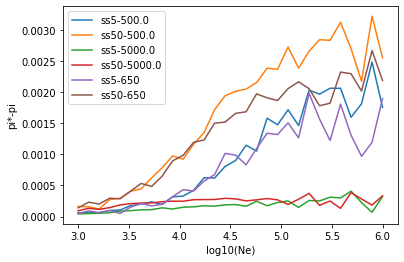

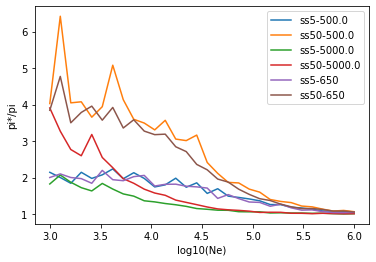

In [13]:
ax5e2 = plot_diffs(df5_5e2, df50_5e2, length=5e2)
ax5e3 = plot_diffs(df5_5e2, df50_5e2, length=5e2, diff='div')
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e2, length=5e3)
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e3, length=5e3, diff='div')
_ = plot_diffs(df5_650, df50_650, ax=ax5e2, length=650)
_ = plot_diffs(df5_650, df50_650, ax=ax5e3, length=650, diff='div')

In [1]:
plot_dict(res_dict, subset=subset)
plot_dict(res_dict, subset=subset, diff='div')

NameError: name 'plot_dict' is not defined